<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simple-Linear-GAN" data-toc-modified-id="Simple-Linear-GAN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simple Linear GAN</a></span></li><li><span><a href="#Getting-Started--With-imports" data-toc-modified-id="Getting-Started--With-imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Getting Started  With imports</a></span></li><li><span><a href="#Generator" data-toc-modified-id="Generator-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generator</a></span></li><li><span><a href="#Noise-Generation" data-toc-modified-id="Noise-Generation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Noise Generation</a></span></li><li><span><a href="#Discriminator" data-toc-modified-id="Discriminator-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Discriminator</a></span></li><li><span><a href="#loss-Function" data-toc-modified-id="loss-Function-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>loss Function</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Training</a></span></li></ul></div>

# Simple Linear GAN

[PyTorch documentation](https://pytorch.org/docs/stable/index.html) 

# Getting Started  With imports



In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.cuda.empty_cache()
torch.manual_seed(0)

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    #plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    return plt.imshow(image_grid.permute(1, 2, 0).squeeze())

**Data used : MNIST Dataset**
The training images your discriminator will be using is from a dataset called [MNIST](http://yann.lecun.com/exdb/mnist/). It contains 60,000 images of handwritten digits, from 0 to 9.

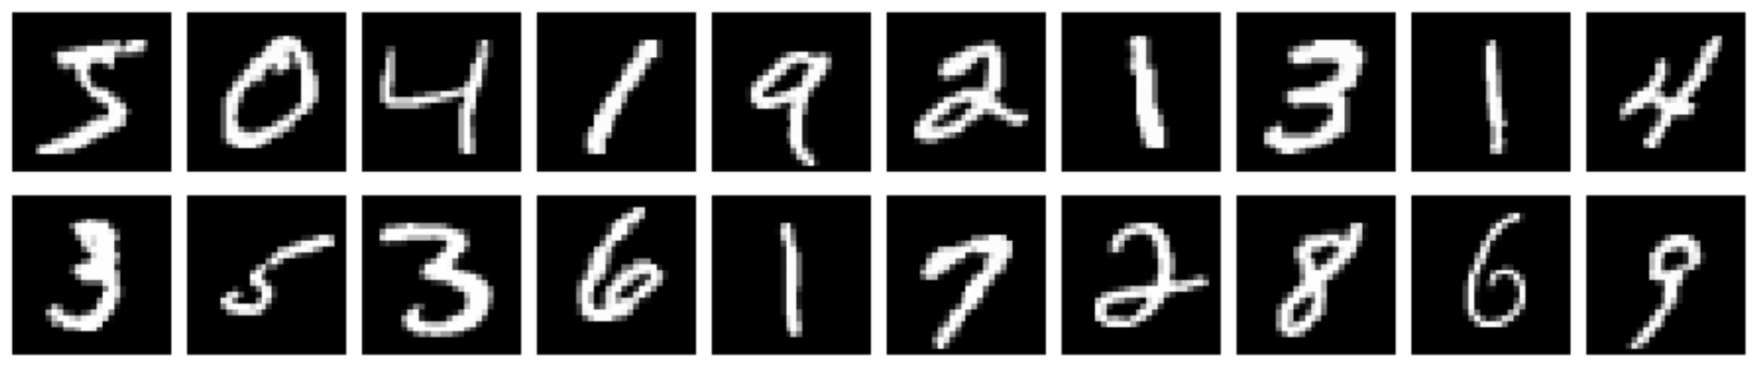

# Generator  
**Generator  Blocks**
the block consist of one Hidden layer and one relu activation

**Generator Module**
consist of 4 blocks means 4 Hidden layers each layer followed by relu activation the output layer ( linear and sigmoid activation).

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, epsi_dim=10, image_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self.block(epsi_dim, hidden_dim),
            self.block(hidden_dim, hidden_dim * 2),
            self.block(hidden_dim * 2, hidden_dim * 4),
            self.block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, image_dim),
            nn.Sigmoid()
        )
    def block(self,input_dim, output_dim):
        return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.ReLU(inplace=True) 
                        )
    
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    

# Noise Generation

In [3]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples,z_dim,device=device)


# Discriminator

**Discriminator  Blocks**
the block consist of one Hidden layer and one Leaky-relu activation.

**Discriminator Module**
consist of 3 blocks means 3 Hidden layers each layer followed by Leaky-relu activation the output linear layer.


In [4]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.block(im_dim, hidden_dim * 4),
            self.block(hidden_dim * 4, hidden_dim * 2),
            self.block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )
        
    def block(self,input_dim, output_dim):
        return nn.Sequential(
         nn.Linear(input_dim, output_dim), 
         nn.Dropout(p=0.4, inplace=True),
         nn.LeakyReLU(0.2, inplace=True)
                        )
    
    def forward(self, image):
        return self.disc(image)

# loss Function

In [5]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

In [6]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

# Training

*   criterion: the loss function
*   n_epochs: the number of times you iterate through the entire dataset when training
*   z_dim: the dimension of the noise vector
*   display_epoch: how often to display/visualize the images
*   batch_size: the number of images per forward/backward pass
*   lr: the learning rate
*   device: using a GPU (CUDA)

In [7]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 100
z_dim = 64
display_epoch = 5
batch_size = 512

lr = 0.00001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Load MNIST dataset as tensors
dataloader = DataLoader( MNIST('.', download=False, transform=transforms.ToTensor()),
                            batch_size=batch_size,
                            shuffle=True)
steps_per_ep =len(dataloader)
gen = Generator(z_dim,784, 128).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(784, 128).to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

gen_loss = False
error = False

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 1 ,Step:117 ,Generator loss: 0.859239263049627 ,discriminator loss: 0.6208402862993335


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 2 ,Step:235 ,Generator loss: 1.3382307088981233 ,discriminator loss: 0.4316825139320502


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 3 ,Step:353 ,Generator loss: 1.129153358734261 ,discriminator loss: 0.4619981348514556


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 4 ,Step:471 ,Generator loss: 1.1898844605785308 ,discriminator loss: 0.5142243358038241


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 5 ,Step:589 ,Generator loss: 1.071650831376092 ,discriminator loss: 0.610376747482914


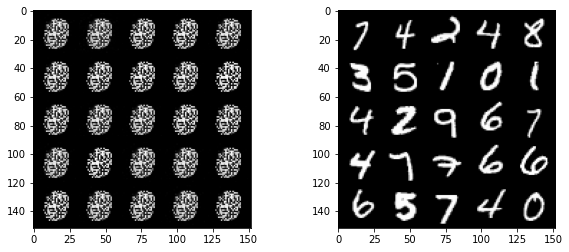

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 6 ,Step:707 ,Generator loss: 1.0185485441805953 ,discriminator loss: 0.5936776414766151


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 7 ,Step:825 ,Generator loss: 1.0552677502066405 ,discriminator loss: 0.5610897687532136


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 8 ,Step:943 ,Generator loss: 0.9878086200204949 ,discriminator loss: 0.5672435437218619


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 9 ,Step:1061 ,Generator loss: 1.0402328008312292 ,discriminator loss: 0.5392861245042185


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 10 ,Step:1179 ,Generator loss: 1.0890754168316472 ,discriminator loss: 0.4835412600788019


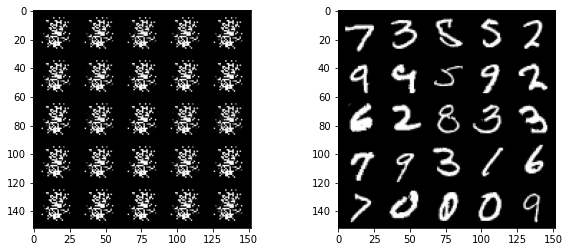

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 11 ,Step:1297 ,Generator loss: 1.0758066803722057 ,discriminator loss: 0.5321929510367118


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 12 ,Step:1415 ,Generator loss: 1.1674052951699603 ,discriminator loss: 0.5015022512209618


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 13 ,Step:1533 ,Generator loss: 1.1988860995082529 ,discriminator loss: 0.5025267070632871


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 14 ,Step:1651 ,Generator loss: 1.1668358586602294 ,discriminator loss: 0.5699906823998792


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 15 ,Step:1769 ,Generator loss: 1.1573132761454181 ,discriminator loss: 0.5875696691416078


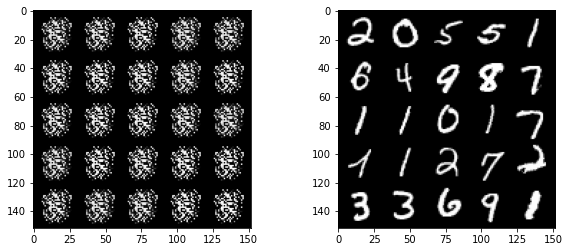

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 16 ,Step:1887 ,Generator loss: 1.2047567034171798 ,discriminator loss: 0.5382746235798982


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 17 ,Step:2005 ,Generator loss: 1.1740075652882203 ,discriminator loss: 0.5230368542469154


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 18 ,Step:2123 ,Generator loss: 1.1716203083426266 ,discriminator loss: 0.49442418374247493


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 19 ,Step:2241 ,Generator loss: 1.3564884208016474 ,discriminator loss: 0.4000744438272411


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 20 ,Step:2359 ,Generator loss: 1.1639588030718144 ,discriminator loss: 0.4858026883359683


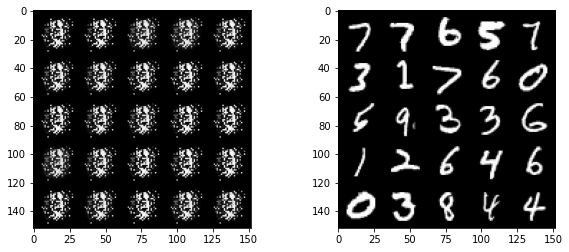

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 21 ,Step:2477 ,Generator loss: 0.9816418360855618 ,discriminator loss: 0.6747445049932449


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 22 ,Step:2595 ,Generator loss: 1.217249691486358 ,discriminator loss: 0.6054829990459699


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 23 ,Step:2713 ,Generator loss: 1.0843255817890163 ,discriminator loss: 0.620831287008221


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 24 ,Step:2831 ,Generator loss: 1.099514503600234 ,discriminator loss: 0.5608930741831408


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 25 ,Step:2949 ,Generator loss: 1.1874682216321006 ,discriminator loss: 0.47224074753664336


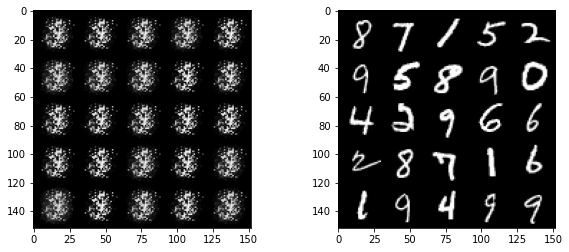

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 26 ,Step:3067 ,Generator loss: 1.0465839843628768 ,discriminator loss: 0.5567543385392529


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 27 ,Step:3185 ,Generator loss: 0.9871990337210186 ,discriminator loss: 0.5657714797278581


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 28 ,Step:3303 ,Generator loss: 0.9671157729827751 ,discriminator loss: 0.5328350693492567


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 29 ,Step:3421 ,Generator loss: 0.9211747469538348 ,discriminator loss: 0.5231360449629315


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 30 ,Step:3539 ,Generator loss: 0.8091411151118197 ,discriminator loss: 0.5804056742433772


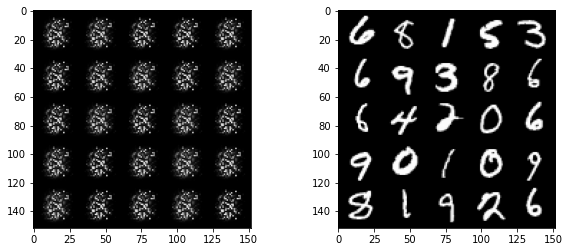

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 31 ,Step:3657 ,Generator loss: 0.8269276664418691 ,discriminator loss: 0.5491985193753646


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 32 ,Step:3775 ,Generator loss: 0.7805490791797635 ,discriminator loss: 0.5580698206263073


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 33 ,Step:3893 ,Generator loss: 0.7308978908142804 ,discriminator loss: 0.563899045778533


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 34 ,Step:4011 ,Generator loss: 0.740061953411264 ,discriminator loss: 0.586211691973573


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 35 ,Step:4129 ,Generator loss: 0.8284851479328287 ,discriminator loss: 0.5496799738730416


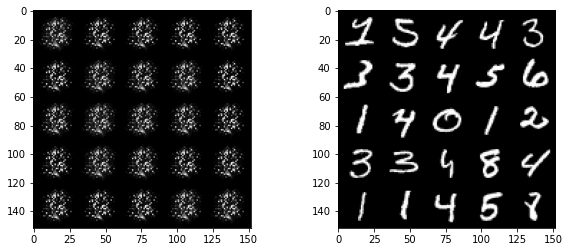

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 36 ,Step:4247 ,Generator loss: 0.9181032190888619 ,discriminator loss: 0.4871566785594166


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 37 ,Step:4365 ,Generator loss: 1.0233038870965019 ,discriminator loss: 0.4466553186461078


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 38 ,Step:4483 ,Generator loss: 1.0148731313519557 ,discriminator loss: 0.4702311251628194


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 39 ,Step:4601 ,Generator loss: 1.331773252810462 ,discriminator loss: 0.36429182907282287


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 40 ,Step:4719 ,Generator loss: 1.356286978317519 ,discriminator loss: 0.40293359327114237


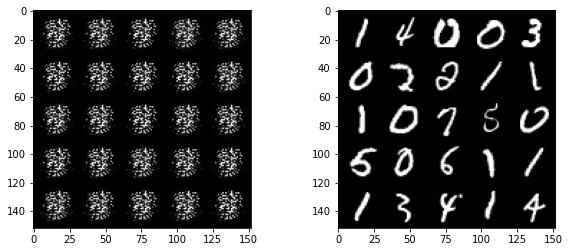

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 41 ,Step:4837 ,Generator loss: 1.3964463280419166 ,discriminator loss: 0.42243422643613


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 42 ,Step:4955 ,Generator loss: 1.730372095512133 ,discriminator loss: 0.30532444003274883


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 43 ,Step:5073 ,Generator loss: 1.8285314208370147 ,discriminator loss: 0.29607942599361237


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 44 ,Step:5191 ,Generator loss: 1.7986977787341103 ,discriminator loss: 0.3150191122697571


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 45 ,Step:5309 ,Generator loss: 1.9496026392710415 ,discriminator loss: 0.2938565217842489


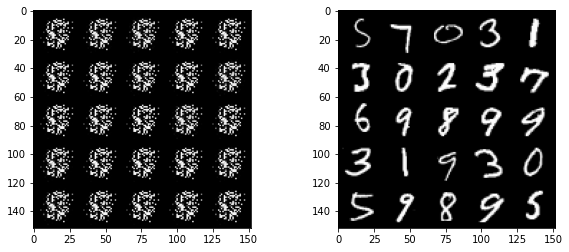

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 46 ,Step:5427 ,Generator loss: 2.4693669686883184 ,discriminator loss: 0.17556481884192615


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 47 ,Step:5545 ,Generator loss: 2.694646350408005 ,discriminator loss: 0.16519563430446682


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 48 ,Step:5663 ,Generator loss: 2.4418999098115055 ,discriminator loss: 0.21116764262571172


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 49 ,Step:5781 ,Generator loss: 2.8006000033879688 ,discriminator loss: 0.1776127595517594


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 50 ,Step:5899 ,Generator loss: 3.0044929657952277 ,discriminator loss: 0.15400419649431257


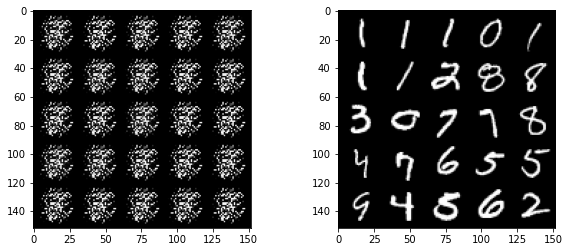

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 51 ,Step:6017 ,Generator loss: 3.0709639221934952 ,discriminator loss: 0.15069670728960277


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 52 ,Step:6135 ,Generator loss: 3.2998515306893053 ,discriminator loss: 0.10296186312275421


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 53 ,Step:6253 ,Generator loss: 3.320829512709279 ,discriminator loss: 0.11368780753622625


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 54 ,Step:6371 ,Generator loss: 3.3098386970617013 ,discriminator loss: 0.11080627755846001


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 55 ,Step:6489 ,Generator loss: 3.3852297007027294 ,discriminator loss: 0.11235919695789531


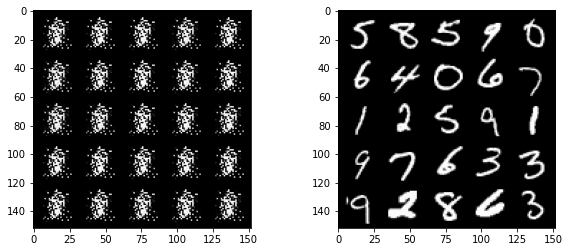

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 56 ,Step:6607 ,Generator loss: 3.321553886946984 ,discriminator loss: 0.13455476649736958


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 57 ,Step:6725 ,Generator loss: 3.265251438496477 ,discriminator loss: 0.15358978844547666


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 58 ,Step:6843 ,Generator loss: 3.30726888826338 ,discriminator loss: 0.15449041930043098


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 59 ,Step:6961 ,Generator loss: 3.9570262310868602 ,discriminator loss: 0.09284439929208513


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 60 ,Step:7079 ,Generator loss: 4.2827455775212435 ,discriminator loss: 0.0805072822308136


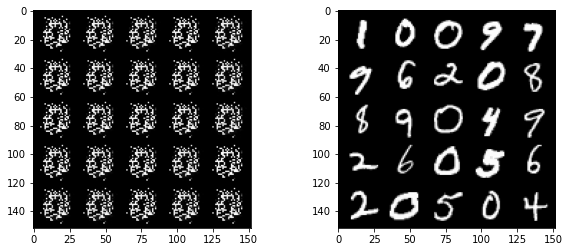

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 61 ,Step:7197 ,Generator loss: 4.235619646007731 ,discriminator loss: 0.06080385221768231


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 62 ,Step:7315 ,Generator loss: 3.863540776705338 ,discriminator loss: 0.08887604141008046


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 63 ,Step:7433 ,Generator loss: 4.049653168451987 ,discriminator loss: 0.0831749174049345


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 64 ,Step:7551 ,Generator loss: 3.638656141394277 ,discriminator loss: 0.10939053313459375


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 65 ,Step:7669 ,Generator loss: 3.878625138331267 ,discriminator loss: 0.06606674131195425


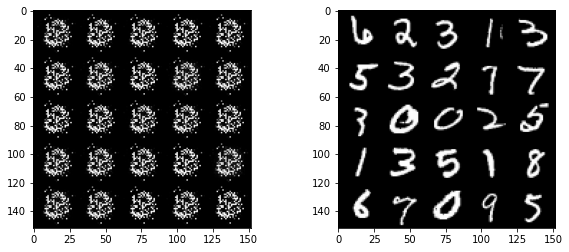

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 66 ,Step:7787 ,Generator loss: 3.822316325316994 ,discriminator loss: 0.07637398528976964


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 67 ,Step:7905 ,Generator loss: 4.048694707579532 ,discriminator loss: 0.08854818817670063


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 68 ,Step:8023 ,Generator loss: 4.0560712491051625 ,discriminator loss: 0.09001256910673638


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 69 ,Step:8141 ,Generator loss: 4.139452728174499 ,discriminator loss: 0.08654988995926863


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 70 ,Step:8259 ,Generator loss: 3.808667298090661 ,discriminator loss: 0.1252745593250808


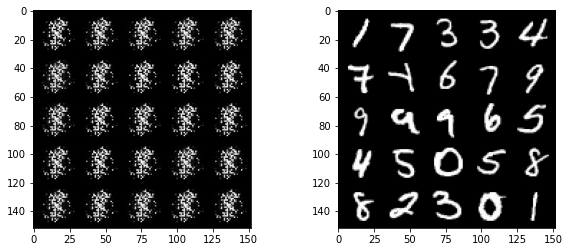

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 71 ,Step:8377 ,Generator loss: 3.4591562121601425 ,discriminator loss: 0.09966937629348138


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 72 ,Step:8495 ,Generator loss: 3.731659450773465 ,discriminator loss: 0.08384158632765384


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 73 ,Step:8613 ,Generator loss: 4.071732215962165 ,discriminator loss: 0.06271776793745615


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 74 ,Step:8731 ,Generator loss: 4.266054610074576 ,discriminator loss: 0.05449827214292551


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 75 ,Step:8849 ,Generator loss: 4.137464250548409 ,discriminator loss: 0.06569305223302316


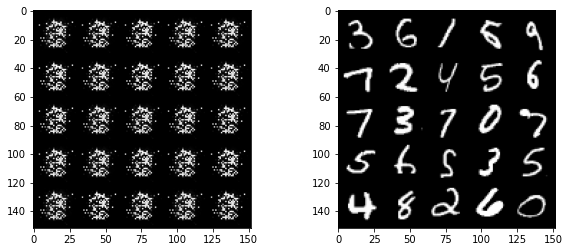

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 76 ,Step:8967 ,Generator loss: 4.053530731443631 ,discriminator loss: 0.07288254746946234


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 77 ,Step:9085 ,Generator loss: 4.509292853080618 ,discriminator loss: 0.05071428238209022


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 78 ,Step:9203 ,Generator loss: 4.548564878560729 ,discriminator loss: 0.03970577236328084


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 79 ,Step:9321 ,Generator loss: 4.477670782703463 ,discriminator loss: 0.0500257136142355


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 80 ,Step:9439 ,Generator loss: 4.452591253539263 ,discriminator loss: 0.06021549609505524


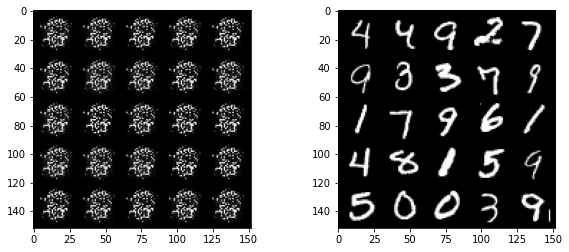

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 81 ,Step:9557 ,Generator loss: 4.690568390539137 ,discriminator loss: 0.06685745422491583


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 82 ,Step:9675 ,Generator loss: 4.315228005587046 ,discriminator loss: 0.07380479997244932


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 83 ,Step:9793 ,Generator loss: 4.437366129988334 ,discriminator loss: 0.04018934015816046


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 84 ,Step:9911 ,Generator loss: 4.696668487484171 ,discriminator loss: 0.03677250563277531


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 85 ,Step:10029 ,Generator loss: 4.566717693361187 ,discriminator loss: 0.04210939210981635


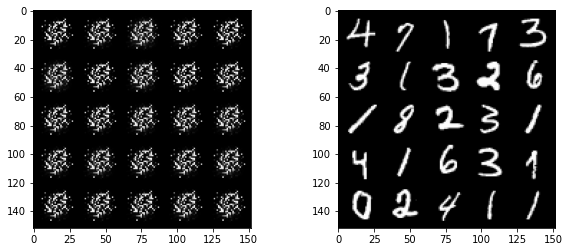

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 86 ,Step:10147 ,Generator loss: 4.662381717714211 ,discriminator loss: 0.05641304316409565


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 87 ,Step:10265 ,Generator loss: 4.475531517449072 ,discriminator loss: 0.060566047174950795


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 88 ,Step:10383 ,Generator loss: 4.405441494311316 ,discriminator loss: 0.06244835087050826


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 89 ,Step:10501 ,Generator loss: 4.834841505955839 ,discriminator loss: 0.050284413557689055


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 90 ,Step:10619 ,Generator loss: 4.514237375582678 ,discriminator loss: 0.10220005110663885


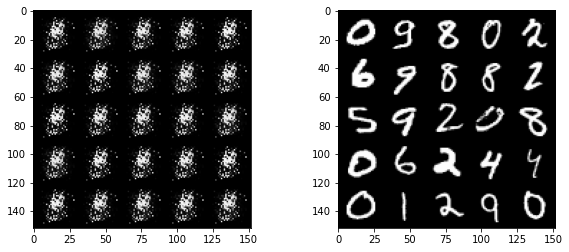

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 91 ,Step:10737 ,Generator loss: 4.8953318110967095 ,discriminator loss: 0.08951847482535799


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 92 ,Step:10855 ,Generator loss: 4.873952720124843 ,discriminator loss: 0.06090424800196948


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 93 ,Step:10973 ,Generator loss: 4.6808022119231145 ,discriminator loss: 0.059945112725688234


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 94 ,Step:11091 ,Generator loss: 4.541647616079297 ,discriminator loss: 0.05664182230198788


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 95 ,Step:11209 ,Generator loss: 4.952192120632882 ,discriminator loss: 0.043209252421254826


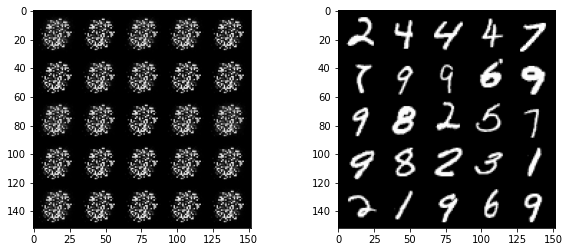

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 96 ,Step:11327 ,Generator loss: 5.066753985518115 ,discriminator loss: 0.047884720645971185


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 97 ,Step:11445 ,Generator loss: 5.692107572393902 ,discriminator loss: 0.04135525556502203


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 98 ,Step:11563 ,Generator loss: 5.89276309336646 ,discriminator loss: 0.03533589467406272


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 99 ,Step:11681 ,Generator loss: 5.610617423461656 ,discriminator loss: 0.047953761845700826


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 100 ,Step:11799 ,Generator loss: 5.659065472877632 ,discriminator loss: 0.04138795666838602


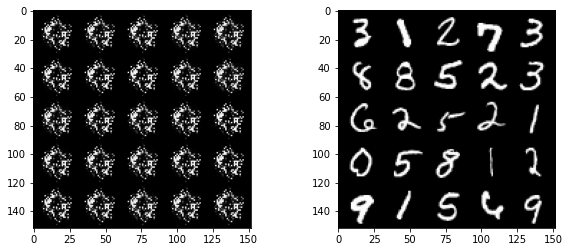

In [8]:
for epoch in range(1,n_epochs+1):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)
        ### Update discriminator ###
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        ### Update generator ###
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
        
        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / steps_per_ep
        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / steps_per_ep
        cur_step += 1
        ### Visualization code ###
       
    print(f"Epoch: {epoch} ,Step:{cur_step-1} ,Generator loss: {mean_generator_loss} ,discriminator loss: {mean_discriminator_loss}")
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    
    if epoch % display_epoch == 0 and display_epoch > 1:
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        plt.figure(1, figsize=(10,4))
        plt.subplot(1,2,1)
        show_tensor_images(fake)
        plt.subplot(1,2,2)
        show_tensor_images(real)
        plt.show()
        
        
